<a href="https://colab.research.google.com/github/Patatone/Network-failure-cause-identification/blob/main/Failure_cause_identification_with_different_failures_location_IPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hyperopt
import time
import sklearn.metrics as mt
import pickle

from xgboost import Booster
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

#XAI-related packages: LIME and SHAP
import lime
import lime.lime_tabular
import shap 
import shap.plots

C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#################################################################################################
###### The function load_window_dataset() that takes in input window data file, and 
###### label to be assigned and returns numpy arrays with features and labels
#################################################################################################

def load_window_dataset(X, y, filename, label):
#Inputs: - X: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only features)
#        - y: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only labels)
#        - filename: full name (with path) of the file to be read (it must be a window dataset file created above)
#        - label: integer, label to be assigned to the datapoints retrieved from filename; it may differ from labels already included in current y
#Outputs: - X: updated X (including features for the new data points retrieved from filename)
#         - y: updated y (including labels for the new data points)
#This function to X and y in input the new datapoints retrieved from filename and return updated X and y
#The function handle the case when X and y are empty (initialized as None)

    data = pd.read_csv(filename)

    if X is None:
        X = data.to_numpy()
        # full() function puts in all X.shape[0] elements the value "label"
        y = np.full(X.shape[0], label)
    else:
        X_temp = data.to_numpy()
        y_temp = np.full(X_temp.shape[0], label)
        X = np.append(X, X_temp, axis = 0) #F: axis=0-->stack X and X_temp vertically (increase no of rows)
        y = np.append(y, y_temp)

    return X, y



In [3]:
##########################################################################################
###### Use function load_window_dataset() with datasets of for all scenarios  
###### using window length = 10 and spacing = 1. Finally, perform features scaling 
##########################################################################################

X=None 
y=None
length=10
spacing=1
folderpath='../Features'

for filename in os.listdir(folderpath):   
    if filename.endswith('_sp' + str(spacing) + '_w' + str(length) + '.dat'):
        print(filename)
        label = 0
        if int(filename[9]) > 5:
          label = 1
        fullname = folderpath + '/' + filename
#------------------------------------------------------------
        X, y = load_window_dataset(X, y, fullname, label)
#------------------------------------------------------------
        print('current shape of X: ' +str(X.shape))
        print('current shape of y: ' +str(y.shape))

# Features scaling 
scaler = StandardScaler()
X = scaler.fit_transform(X)

all_data = {'all': X, 'mean': X[:,[1,2,3,4,5]], 'RMS': X[:,[0,2,3,4,5]], 
            'ptp': X[:,[0,1,3,4,5]], 'std': X[:,[0,1,2,4,5]], 
            'max': X[:,[0,1,2,3,5]], 'min': X[:,[0,1,2,3,4]]}

Scenario_1_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (21591, 6)
current shape of y: (21591,)
Scenario_1_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (43182, 6)
current shape of y: (43182,)
Scenario_1_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
current shape of X: (64773, 6)
current shape of y: (64773,)
Scenario_2_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (86364, 6)
current shape of y: (86364,)
Scenario_2_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (107955, 6)
current shape of y: (107955,)
Scenario_3_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (129546, 6)
current shape of y: (129546,)
Scenario_4_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (151137, 6)
current shape of y: (151137,)
Scenario_4_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (172728, 6)
current shape of y: (172728,)
Scenario_4_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
current shape of

In [4]:
def train_classifier_XGB(X_train, y_train): 
    xgb = XGBClassifier(eta = 0.7, max_depth= 19, subsample = 0.7, verbosity = 0)
    xgb.fit(X_train, y_train)
    return xgb

In [5]:
def train_classifier_DNN(X_train, y_train): 
    size = (10,) * 3
    dnn = MLPClassifier(hidden_layer_sizes=size, activation='logistic',
                                solver='adam', learning_rate='invscaling', max_iter=1000)
    dnn.fit(X_train, y_train)
    return dnn

In [6]:
def train_classifier_KNN(X_train, y_train): 
    knn = KNeighborsClassifier(leaf_size=21, p=2, n_neighbors=4)
    knn.fit(X_train, y_train)
    return knn

In [7]:
################################################################################################################
###### Split into into train/test and call train_classifier_XXX() functions
################################################################################################################

xgb_models = []
dnn_models = []
knn_models = []

all_X_train_X_test_y_train_y_test = []

for key in all_data:
    # Stratify garantees the split all the scenarios among train and test
    # It's like shuffle and split
    # random_state it's a seed to get the same output
    X_train, X_test, y_train, y_test = train_test_split(all_data[key], y, stratify=y, test_size=0.9, random_state=42)
    all_X_train_X_test_y_train_y_test.append([X_train, X_test, y_train, y_test])
    
    if key == 'all':
        print('Training XGB with '+ key +'...')
    else:
        print('Training XGB without '+ key +'...')
    xgb = train_classifier_XGB(X_train, y_train)
    xgb_models.append(xgb)
    
    if key == 'all':
        print('Training MLP with '+ key +'...')
    else:
        print('Training MLP without '+ key +'...')
    dnn = train_classifier_DNN(X_train, y_train)
    dnn_models.append(dnn)
    
    if key == 'all':
        print('Training KNN with '+ key +'...')
    else:
        print('Training KNN without '+ key +'...')
    knn = train_classifier_KNN(X_train, y_train)
    knn_models.append(knn)

Training XGB with all...
Training MLP with all...
Training KNN with all...
Training XGB without mean...
Training MLP without mean...
Training KNN without mean...
Training XGB without RMS...
Training MLP without RMS...
Training KNN without RMS...
Training XGB without ptp...
Training MLP without ptp...
Training KNN without ptp...
Training XGB without std...
Training MLP without std...
Training KNN without std...
Training XGB without max...
Training MLP without max...
Training KNN without max...
Training XGB without min...
Training MLP without min...
Training KNN without min...


In [8]:
########################################################################################################
###### The function performance_eval() takes in input ground truth and predicted labels, 
###### prints results in a result file passed in input, and returns global metrics
########################################################################################################

def performance_eval(y_true, y_pred, lab, l_names):
    
    #Compute metrics and print them
    accuracy = mt.accuracy_score(y_true, y_pred)
    precision = mt.precision_score(y_true, y_pred, labels=lab, average=None) #F: average=None gives per-class results
    global_precision = mt.precision_score(y_true, y_pred, labels=lab, average='weighted') 
    recall = mt.recall_score(y_true, y_pred, labels=lab, average=None)
    global_recall = mt.recall_score(y_true, y_pred, labels=lab, average='weighted') 
    f1score = mt.f1_score(y_true, y_pred, labels=lab, average=None)
    global_f1score = mt.f1_score(y_true, y_pred, labels=lab, average='weighted')

    return accuracy, global_precision, global_recall, global_f1score 


In [9]:
##############################################################################################################
###### Load models into NEW models, perform prediction and evaluate performance using performance_eval() 
##############################################################################################################

lbl = [0, 1]
label_names=['Attenuation', 'Filtering']

XGB_all_metrics = []
DNN_all_metrics = []
KNN_all_metrics = []

for i in range(7):
    # Added to fix: 'XGBClassifier' object has no attribute '_le'
    xgb_models[i]._le = LabelEncoder().fit(all_X_train_X_test_y_train_y_test[i][3])

    y_pred_XGB = xgb_models[i].predict(all_X_train_X_test_y_train_y_test[i][1])
    y_pred_DNN = dnn_models[i].predict(all_X_train_X_test_y_train_y_test[i][1])
    y_pred_KNN = knn_models[i].predict(all_X_train_X_test_y_train_y_test[i][1])

    XGB_all_metrics.append(performance_eval(all_X_train_X_test_y_train_y_test[i][3], y_pred_XGB, lbl, label_names))
    DNN_all_metrics.append(performance_eval(all_X_train_X_test_y_train_y_test[i][3], y_pred_DNN, lbl, label_names))
    KNN_all_metrics.append(performance_eval(all_X_train_X_test_y_train_y_test[i][3], y_pred_KNN, lbl, label_names))

print(XGB_all_metrics)
print(DNN_all_metrics)
print(KNN_all_metrics)

[(0.9986175601218827, 0.9986175510899372, 0.9986175601218827, 0.9986173312159422), (0.99858905620687, 0.9985890121644716, 0.99858905620687, 0.998588837485355), (0.9985605522918573, 0.9985604861744091, 0.9985605522918573, 0.9985603382732954), (0.9984379854573026, 0.9984379456471809, 0.9984379854573026, 0.9984377086631693), (0.9985320483768445, 0.9985319331719791, 0.9985320483768445, 0.9985318704159483), (0.9984693397638166, 0.9984693025978412, 0.9984693397638166, 0.9984690733778996), (0.998537749159847, 0.9985377540214857, 0.998537749159847, 0.9985374854085979)]
[(0.9945928073220857, 0.9946074706545421, 0.9945928073220857, 0.9945854837362135), (0.9945614530155716, 0.9945718174080497, 0.9945614530155716, 0.9945548566191396), (0.9945899569305844, 0.9946059902358642, 0.9945899569305844, 0.9945824011398102), (0.9930564463028997, 0.9930630624313018, 0.9930564463028997, 0.9930480394696192), (0.9944901932280399, 0.9945143164951699, 0.9944901932280399, 0.9944812365890457), (0.9947809331611697, 

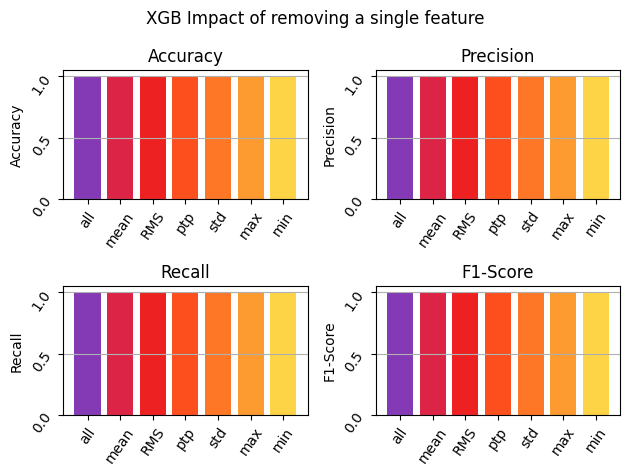

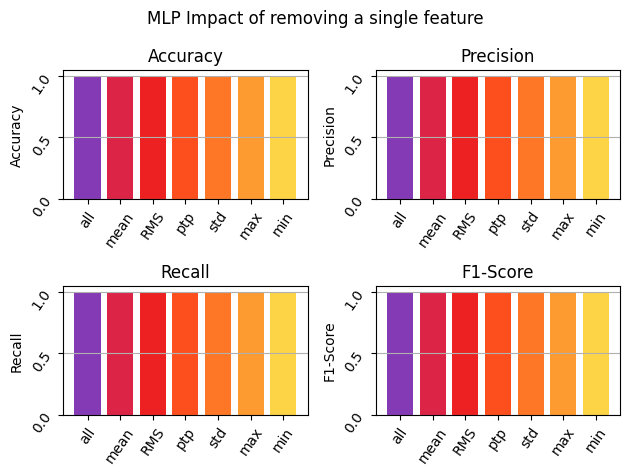

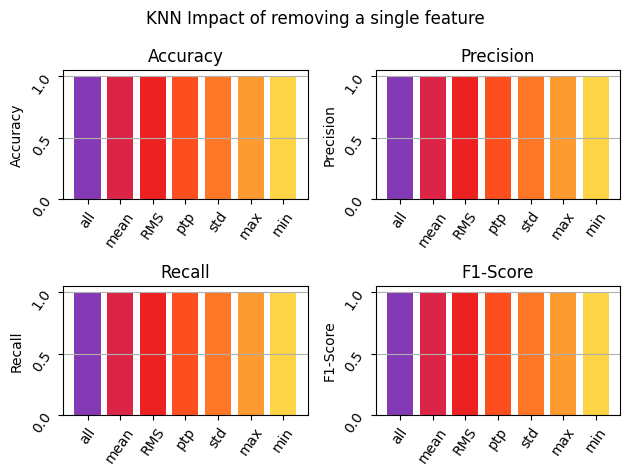

In [10]:
fig_folder = '1_1_Figures'
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

all_metrics = [XGB_all_metrics, DNN_all_metrics, KNN_all_metrics]
models_name = ['XGB', 'MLP', 'KNN']
bar_colors = [(131/255,58/255,180/255), (220/255,37/255,70/255), (237/255,33/255,33/255), 
              (253/255,79/255,29/255), (253/255,119/255,38/255), (253/255,154/255,48/255), 
              (252/255,212/255,69/255)]

for i in range(len(models_name)):
    fig, axs = plt.subplots(nrows=2, ncols=2)

    axs[0,0].bar(all_data.keys(), [item[0] for item in all_metrics[i]], color=bar_colors)
    axs[0,0].tick_params(labelrotation=55)
    axs[0,0].set_title('Accuracy')
    axs[0,0].set_ylabel('Accuracy')
    axs[0,0].yaxis.grid(True)

    axs[0,1].bar(all_data.keys(), [item[1] for item in all_metrics[i]], color=bar_colors)
    axs[0,1].tick_params(labelrotation=55)
    axs[0,1].set_title('Precision')
    axs[0,1].set_ylabel('Precision')
    axs[0,1].yaxis.grid(True)

    axs[1,0].bar(all_data.keys(), [item[2] for item in all_metrics[i]], color=bar_colors)
    axs[1,0].tick_params(labelrotation=55)
    axs[1,0].set_title('Recall')
    axs[1,0].set_ylabel('Recall')
    axs[1,0].yaxis.grid(True)

    axs[1,1].bar(all_data.keys(), [item[3] for item in all_metrics[i]], color=bar_colors)
    axs[1,1].tick_params(labelrotation=55)
    axs[1,1].set_title('F1-Score')
    axs[1,1].set_ylabel('F1-Score')
    axs[1,1].yaxis.grid(True)

    #axs[1,0].set_xlabel('Without the specified feature')
    #axs[1,1].set_xlabel('Without the specified feature')

    image_title = models_name[i] + ' Impact of removing a single feature'
    fig.suptitle(image_title)
    
    fig.tight_layout()
    fig.savefig(fig_folder+'/'+image_title.replace(" ", "_")+'.png')